In [1]:
#-----------------------------------------parameter-----------------------------------------
# min_shared_counts = 10 | 删除没有同时有10个spliced and unspliced counts的基因
# n_top_genes = 3000 | 取top 多少的high variable gene (这些基因被认为是更能生物学差异的)
# n_pcs=30 | 使用的PC数
# n_neighbors=20 | 临近细胞的数量
# min_likelihood | Minimal likelihood for velocity genes to fit the model on
# min_likelihood_time | Minimal likelihood fitness for genes to be included to the weighting
# size | 图片大小
# number_genes | 想要展示的基因数目
# n_convolve | smooth gene expression的程度
# var_names 你感兴趣的基因
# color 细胞的颜色分组
# col_color 细胞label分组
# groups_paga paga的分组
#-----------------------------------------parameter-----------------------------------------

In [1]:
#-----------------------加载相关的包--------------------------------------------
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib as plt
import IPython
import cellrank as cr
import scanpy as sc
#-----------------------加载相关的包--------------------------------------------

In [2]:
#----------------一些进程还有画图参数设置----------------------------
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',dpi=150,dpi_save=300)
#----------------一些进程还有画图参数设置--------------------------------

In [3]:
#----------------读入spliced counts---------------------------------
s = scv.read("./spliced.csv")
s
#----------------读入spliced counts---------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084

In [4]:
#----------------读入unspliced counts---------------------------------
u = scv.read("./unspliced.csv")
u
#----------------读入unspliced counts---------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084

In [5]:
#------------------------组合成anndata object-----------------------------------------
adata = s
adata.layers['spliced'] = s.X
adata.layers['unspliced'] = u.X
adata
#------------------------组合成anndata object-----------------------------------------

AnnData object with n_obs × n_vars = 3187 × 24084
    layers: 'spliced', 'unspliced'

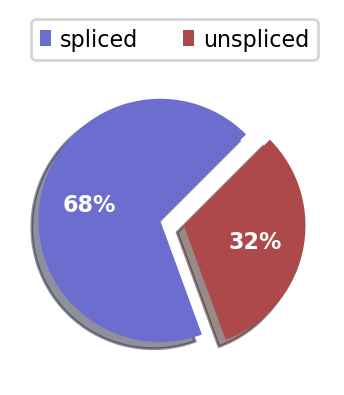

In [6]:
#----------------------------------unspliced coounts 的比例，一般要在15%以上---------------------
scv.pl.proportions(adata)
#----------------------------------unspliced coounts 的比例，一般要在15%以上---------------------

In [7]:
#---------------------------------读入metadata-----------------------------
m = pd.read_csv("./metadata.csv", index_col=0)
m
adata.obs = m
#---------------------------------读入metadata-----------------------------

In [8]:
#----------------------------------读入细胞UMAP 坐标-----------------------------
umap = pd.read_csv('./cell_embeddings.csv')
umap
umap = umap.iloc[:,1:]
umap
#----------------------------------读入细胞UMAP 坐标-----------------------------

,UMAP_1,UMAP_2
0,0.088325,-1.833405
1,-0.202251,4.213624
2,-2.638725,2.088745
3,-1.338910,-6.483031
4,-2.370549,-9.392575
...,...,...
3182,0.570493,-3.560979
3183,4.090896,-2.805602
3184,-5.576463,2.649315
3185,-4.389531,2.005273


In [9]:
#---------------------------------------赋值到object中-------------------------------------
adata.obsm['X_umap'] = umap.values
adata.obsm['X_umap']
#---------------------------------------赋值到object中-------------------------------------

array([[ 0.08832481, -1.83340495],
       [-0.20225141,  4.21362366],
       [-2.63872478,  2.08874525],
       ...,
       [-5.57646344,  2.64931454],
       [-4.38953087,  2.00527276],
       [-0.38245687, -2.86115866]])

In [10]:
#------------------------------------------------写出数据--------------------------------------------
adata.write('./Covid19.h5ad', compression='gzip')
#------------------------------------------------写出数据--------------------------------------------

... storing 'orig.ident' as categorical
... storing 'singler' as categorical
... storing 'Admission.level' as categorical
... storing 'cell.type.fine' as categorical
... storing 'cell.type.coarse' as categorical
... storing 'cell.type' as categorical
... storing 'Donor.orig' as categorical
... storing 'Donor.full' as categorical
... storing 'Donor' as categorical
... storing 'Status' as categorical
... storing 'Sex' as categorical
... storing 'Admission' as categorical
... storing 'Ventilated' as categorical


In [46]:
#-----------------------------------读入已经保存的数据-----------------------------------------
adata = scv.read('./Covid19.h5ad')
#-----------------------------------读入已经保存的数据-----------------------------------------

In [47]:
#---------------------看一些数据结构-------------------------------------------------
adata
#---------------------看一些数据结构-------------------------------------------------

AnnData object with n_obs × n_vars = 3187 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rrna', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'seurat_clusters', 'singler', 'Admission.level', 'cell.type.fine', 'cell.type.coarse', 'cell.type', 'IFN1', 'HLA1', 'Donor.orig', 'Donor.full', 'Donor', 'Status', 'Sex', 'DPS', 'DTF', 'Admission', 'Ventilated', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'cell.t

In [38]:
#--------------------------------------Preprocess------------------------------------------
min_shared_counts = 10
n_top_genes = 3000
scv.pp.filter_and_normalize(adata, min_shared_counts=min_shared_counts, n_top_genes=n_top_genes)

n_pcs=30
n_neighbors=20
scv.pp.moments(adata, n_pcs=n_pcs, n_neighbors=n_neighbors)

scv.tl.recover_dynamics(adata)

min_likelihood=0.001

scv.tl.velocity(adata, min_likelihood=min_likelihood)
#--------------------------------------Preprocess------------------------------------------

Filtered out 17389 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:01:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
color='cell.type.fine'

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


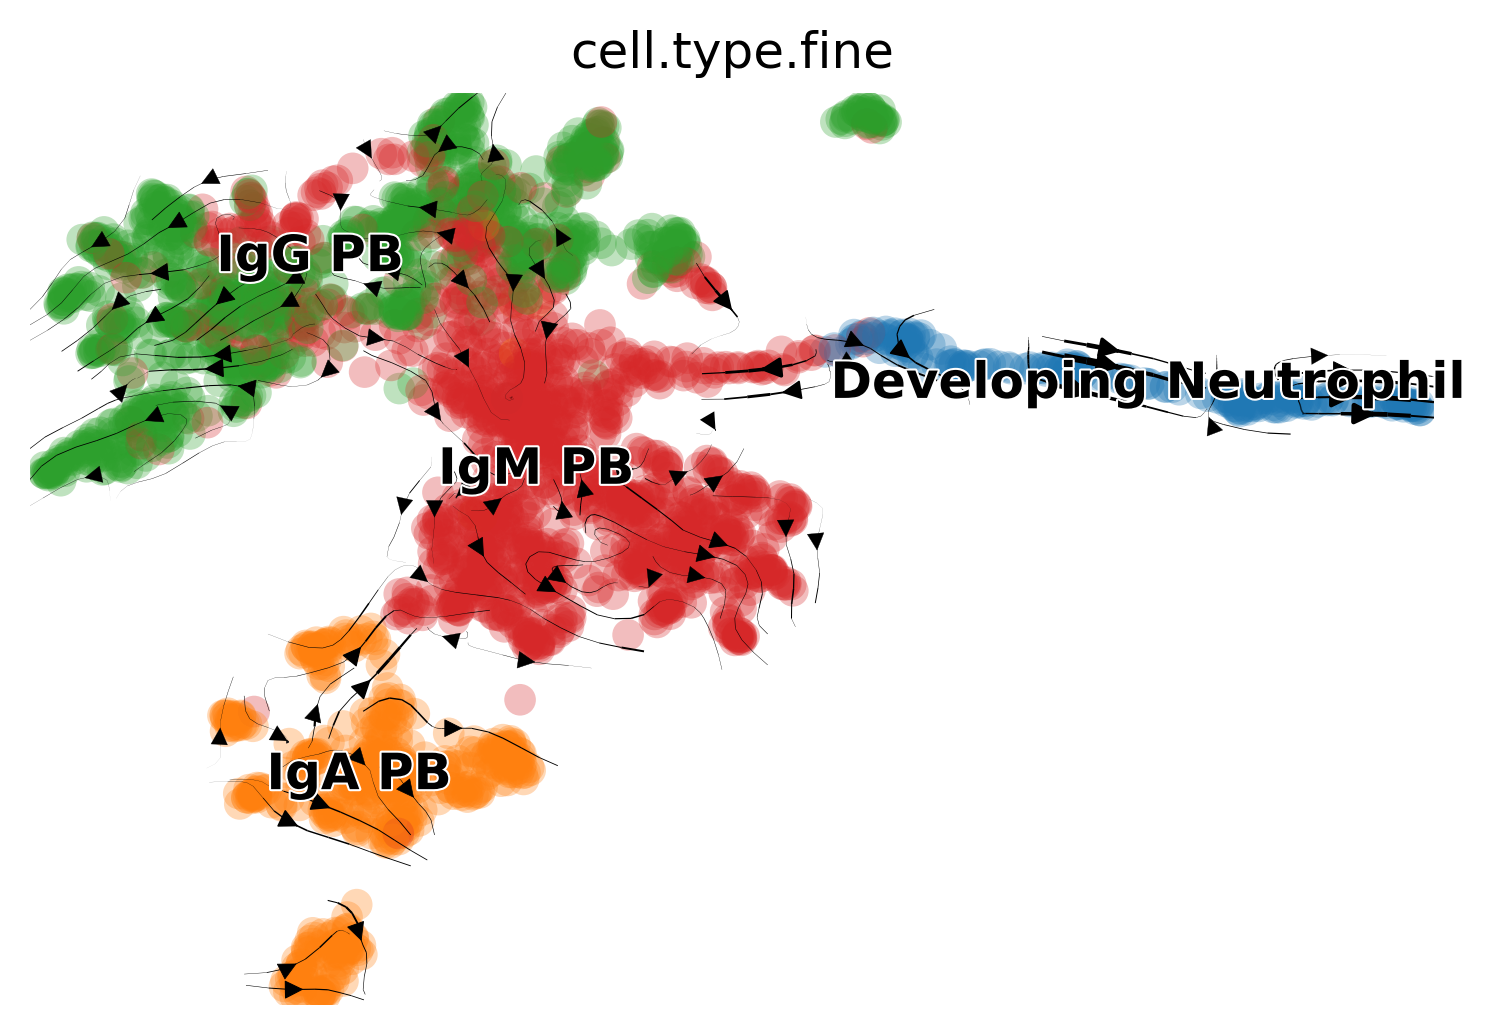

computing terminal states
    identified 0 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


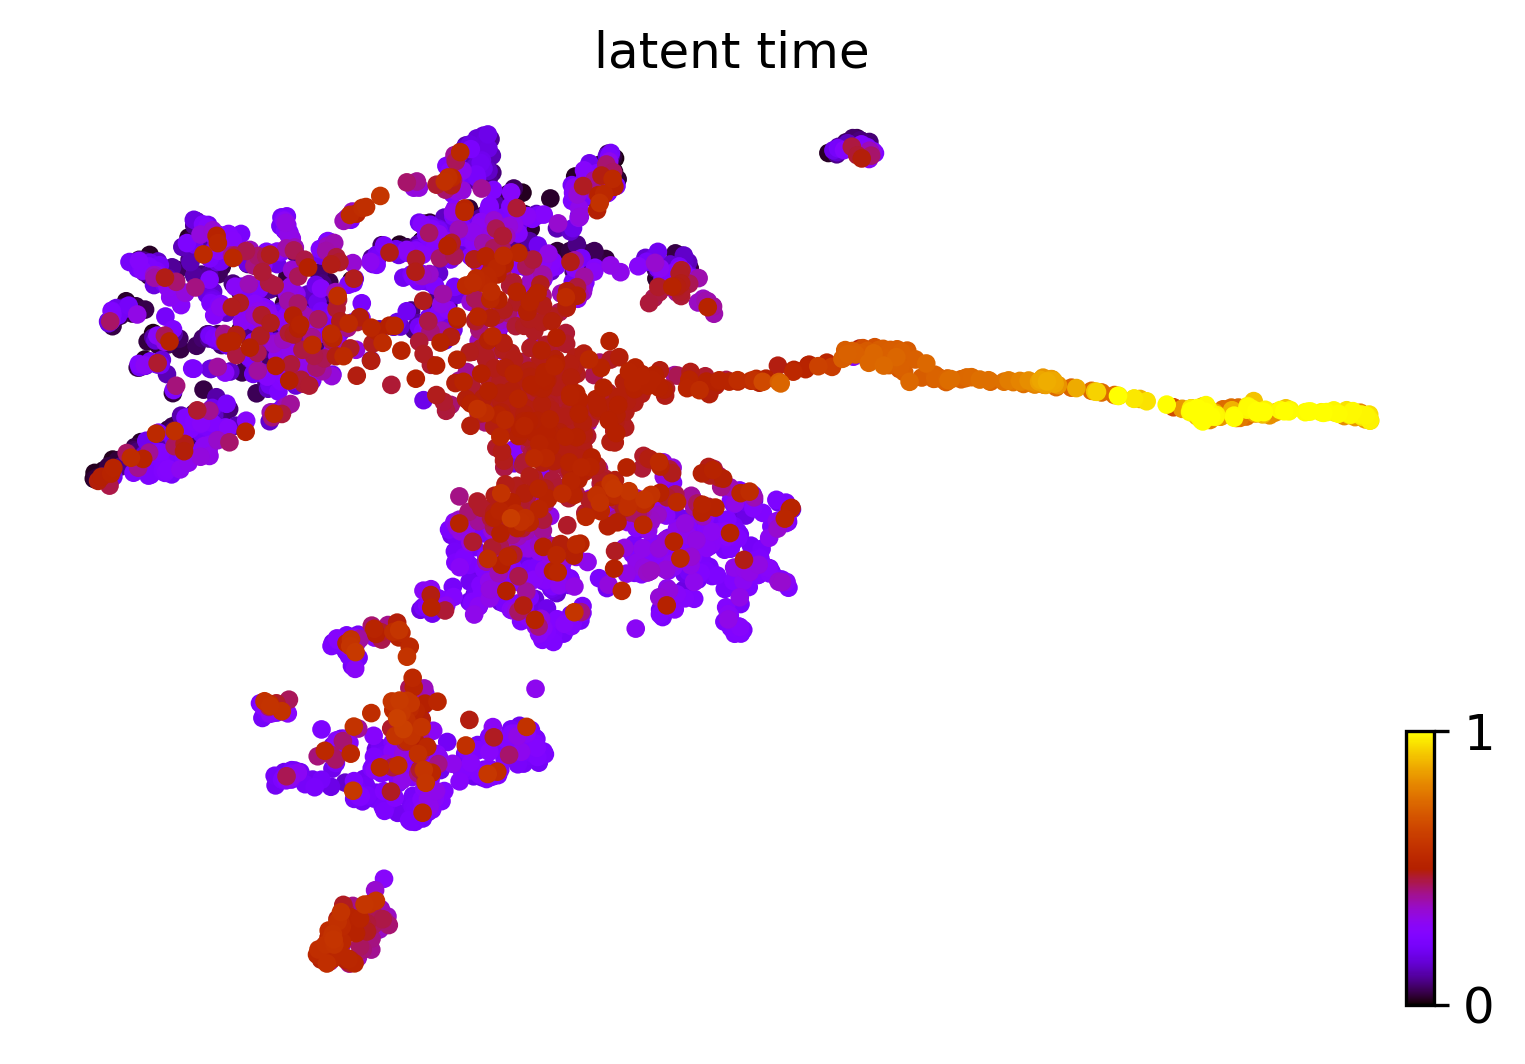

In [40]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap',color=color)

#####latent time
#scv.tl.terminal_states(adata)
min_likelihood_time=0.1

scv.tl.latent_time(adata, min_likelihood=min_likelihood_time)

size = 80
scv.pl.scatter(adata, color='latent_time',color_map='gnuplot', size=size)

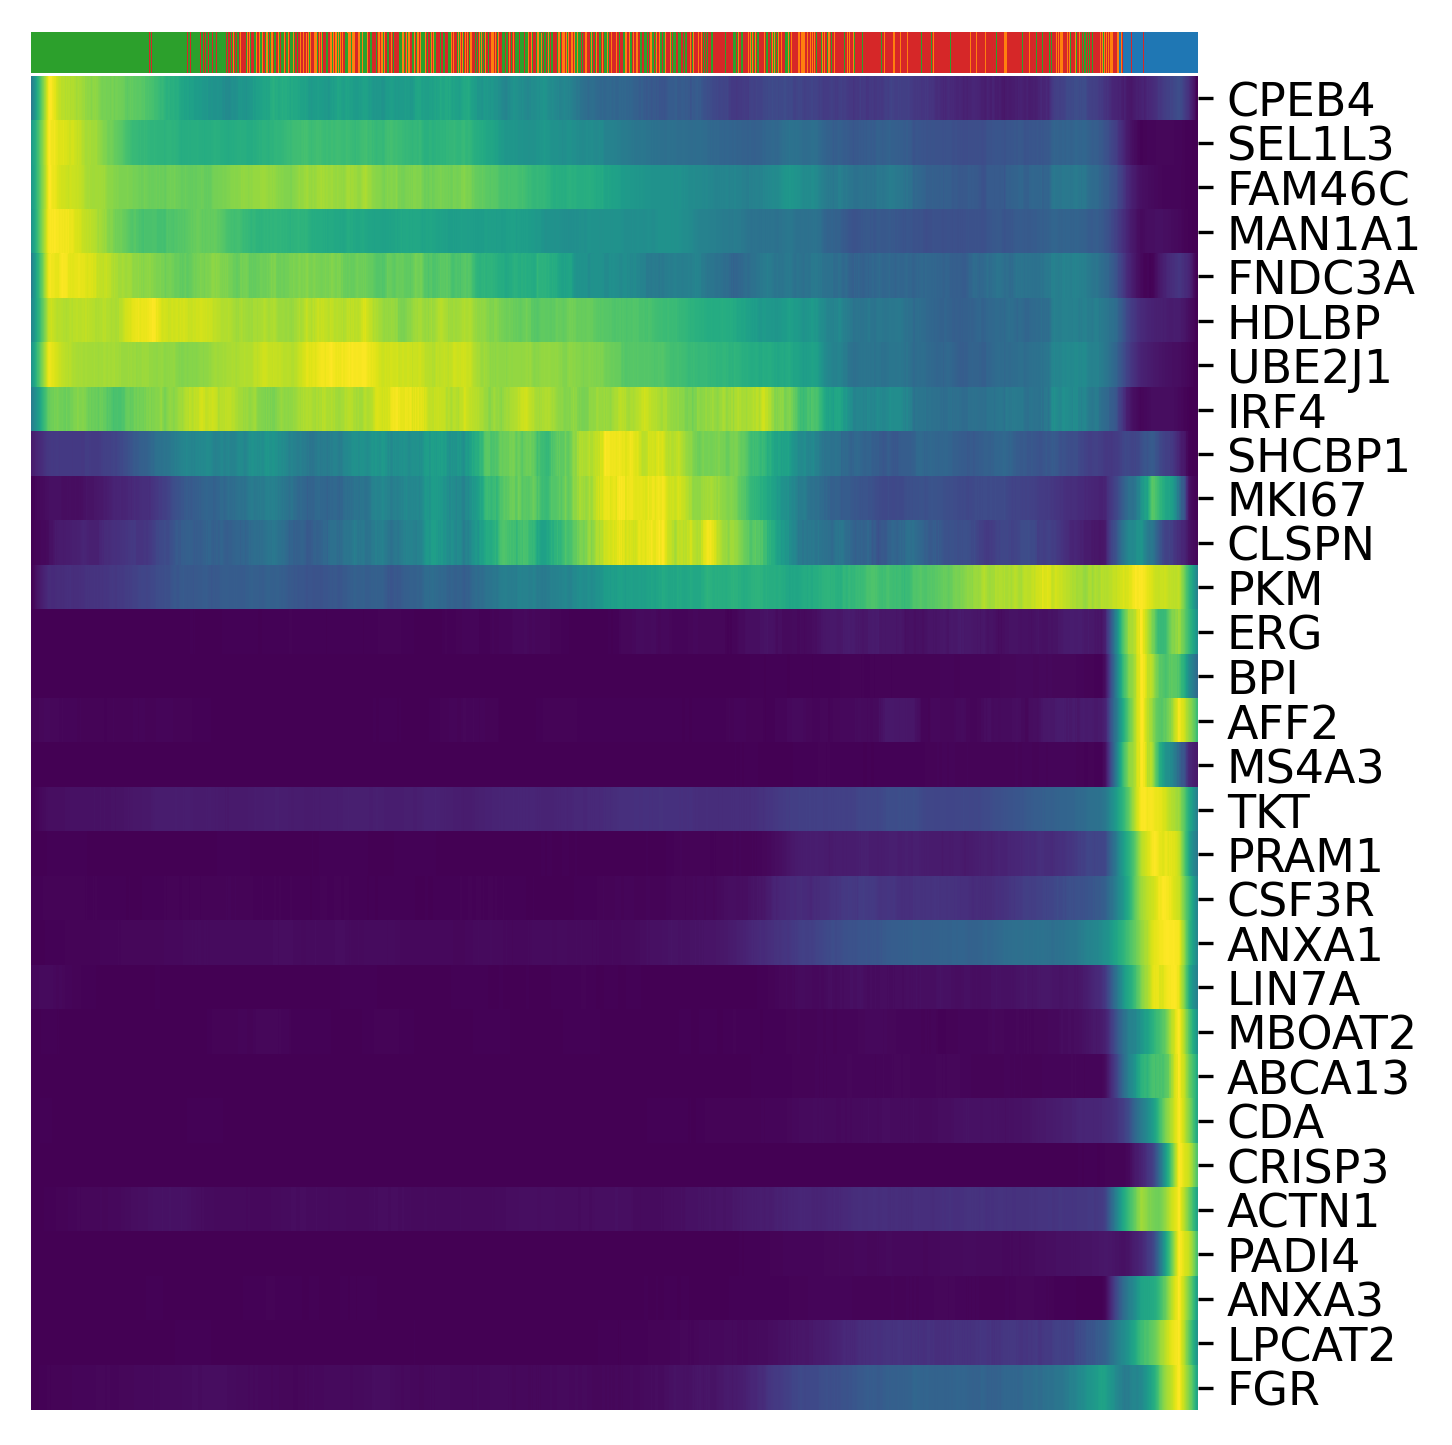

In [32]:
number_genes = 30
n_convolve = 100
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:number_genes]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='cell.type.fine', n_convolve=n_convolve, yticklabels = True, figsize=(5, 5))

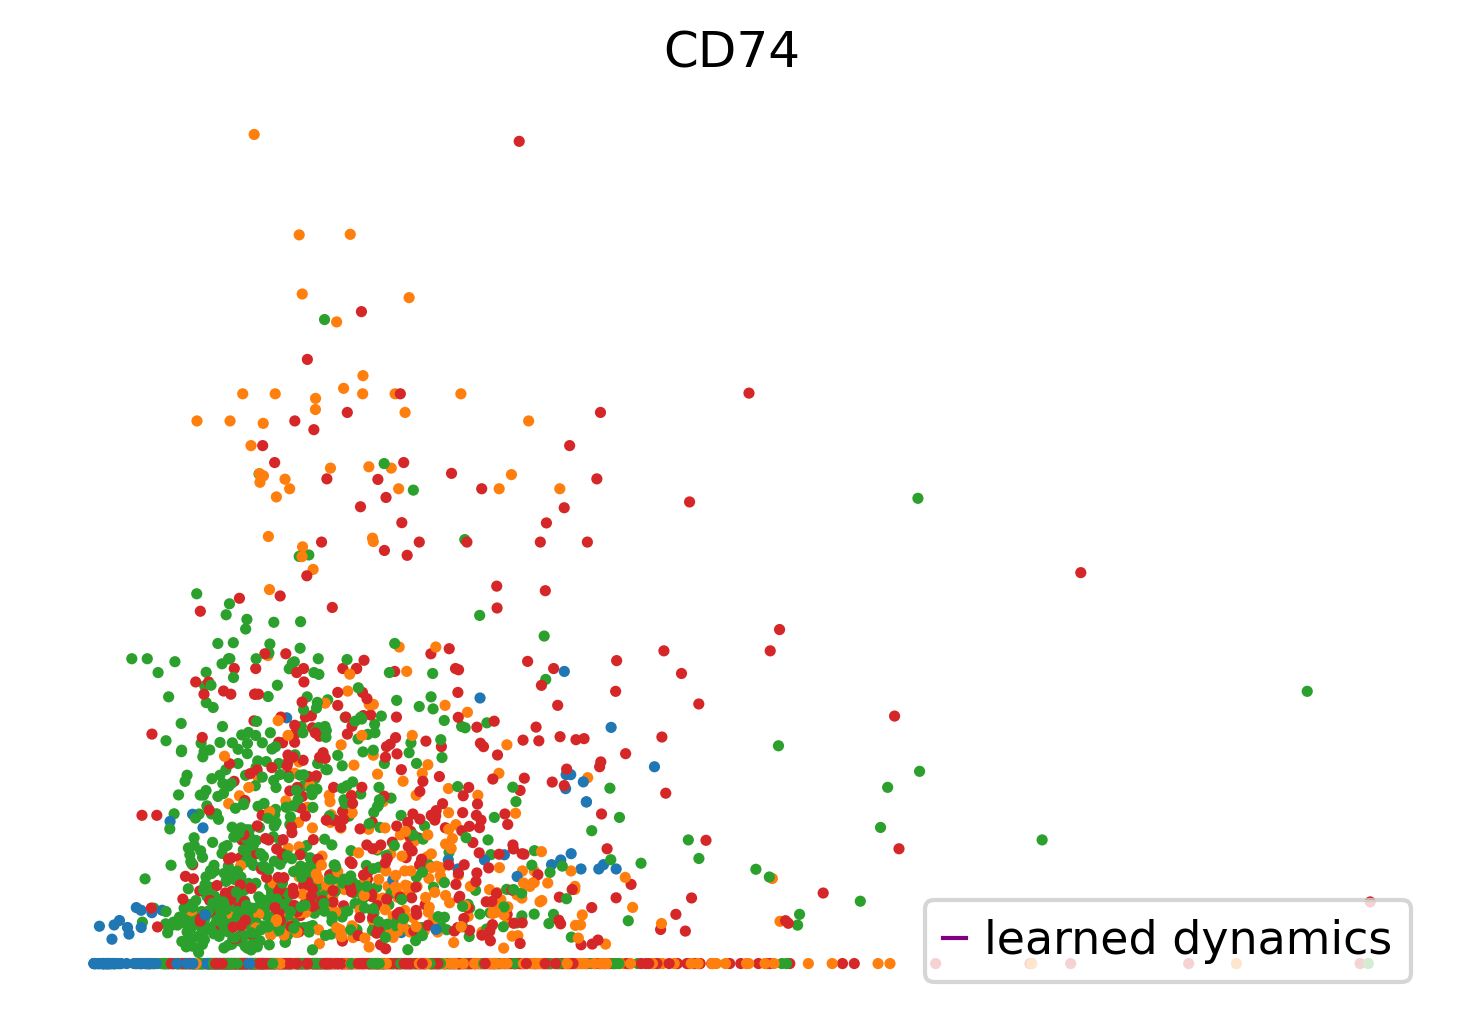

In [27]:
# top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
# scv.pl.scatter(adata, basis=var_names, ncols=5, frameon=False, color='cell.type.fine')

In [87]:
"""
写出所有用于estimate velocity的gene到csv文件里面，用户可从这个文件中看到可用于展示的基因
"""

adata.var.velocity_genes[adata.var.velocity_genes == True].index.to_series().to_csv('velocity_gene.csv', index=None, header=['Gene'])

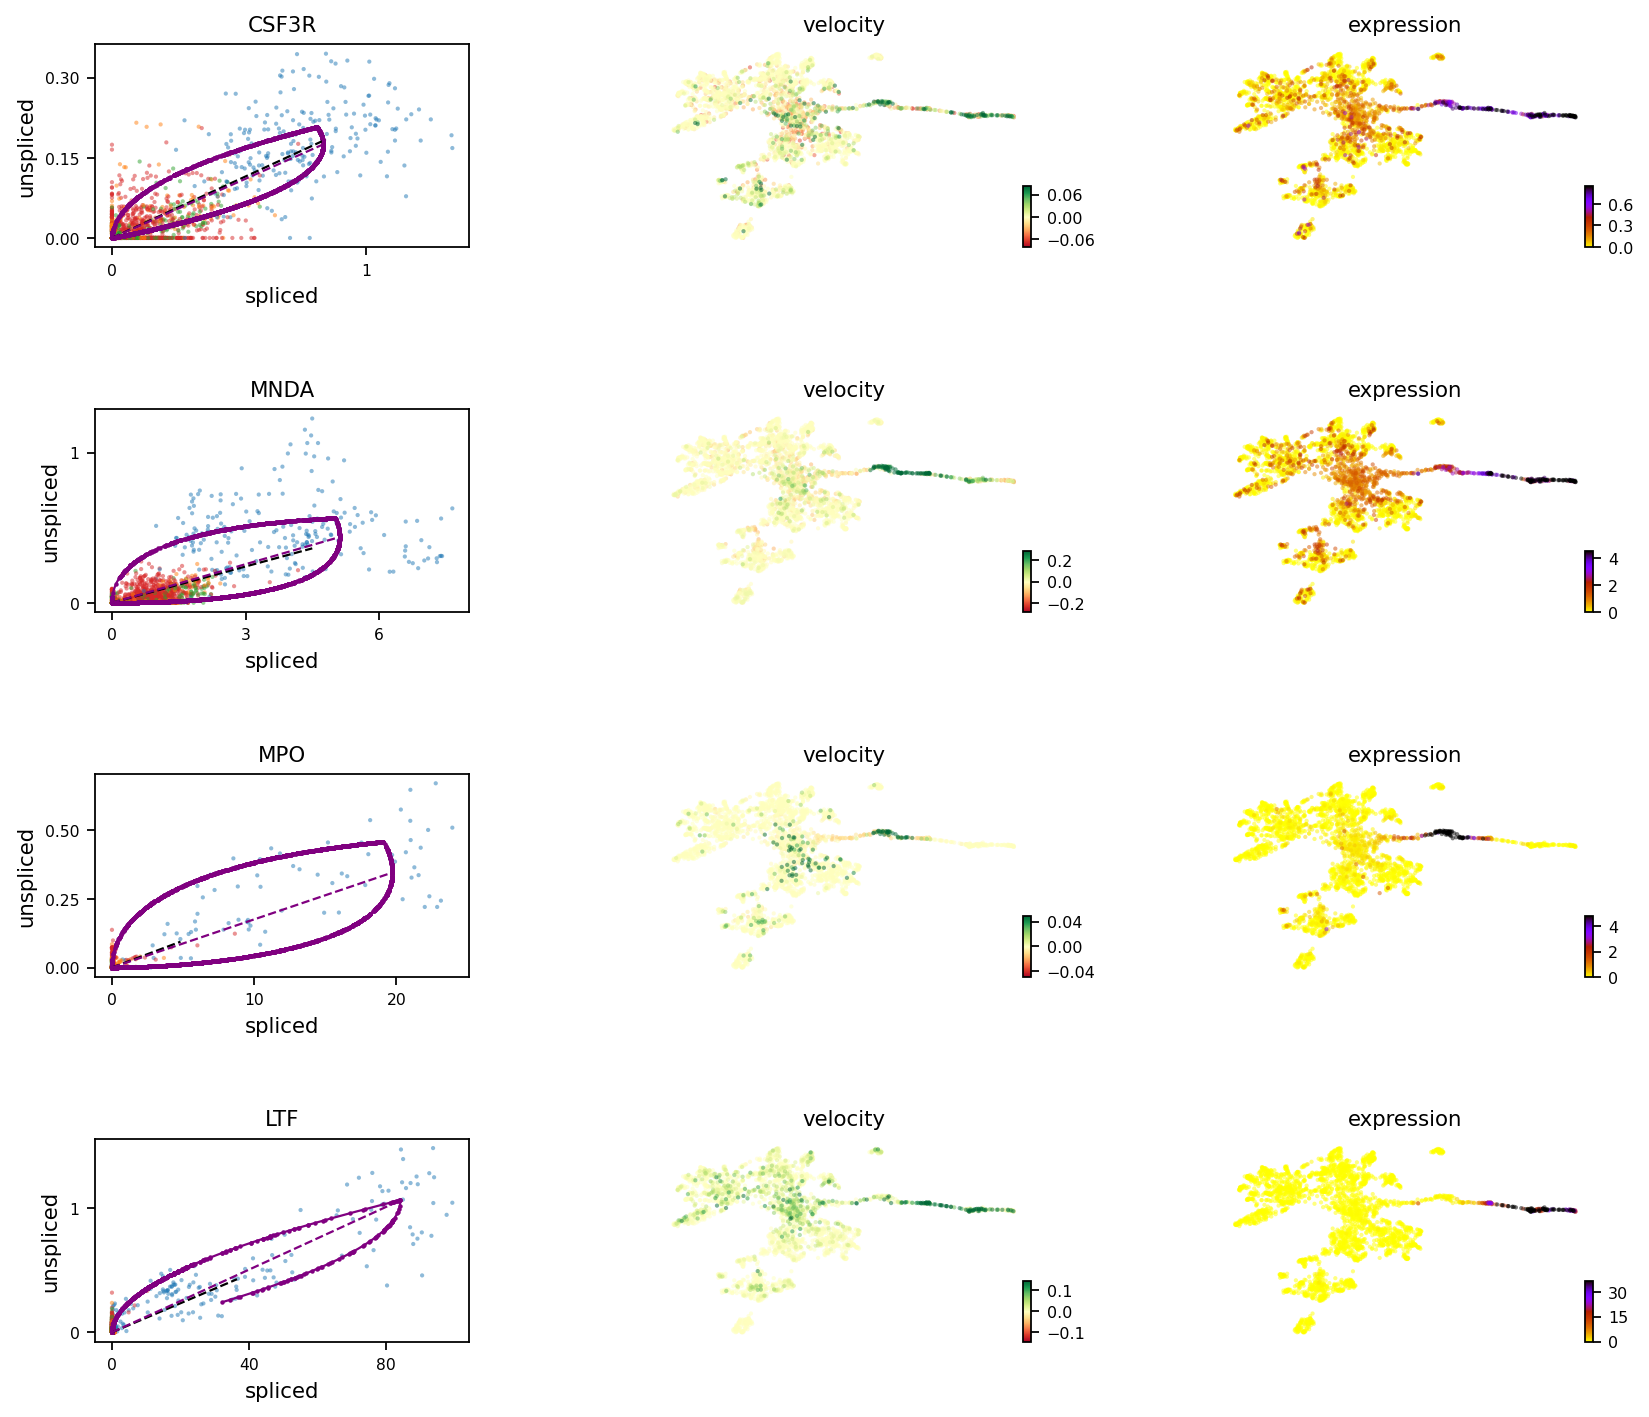

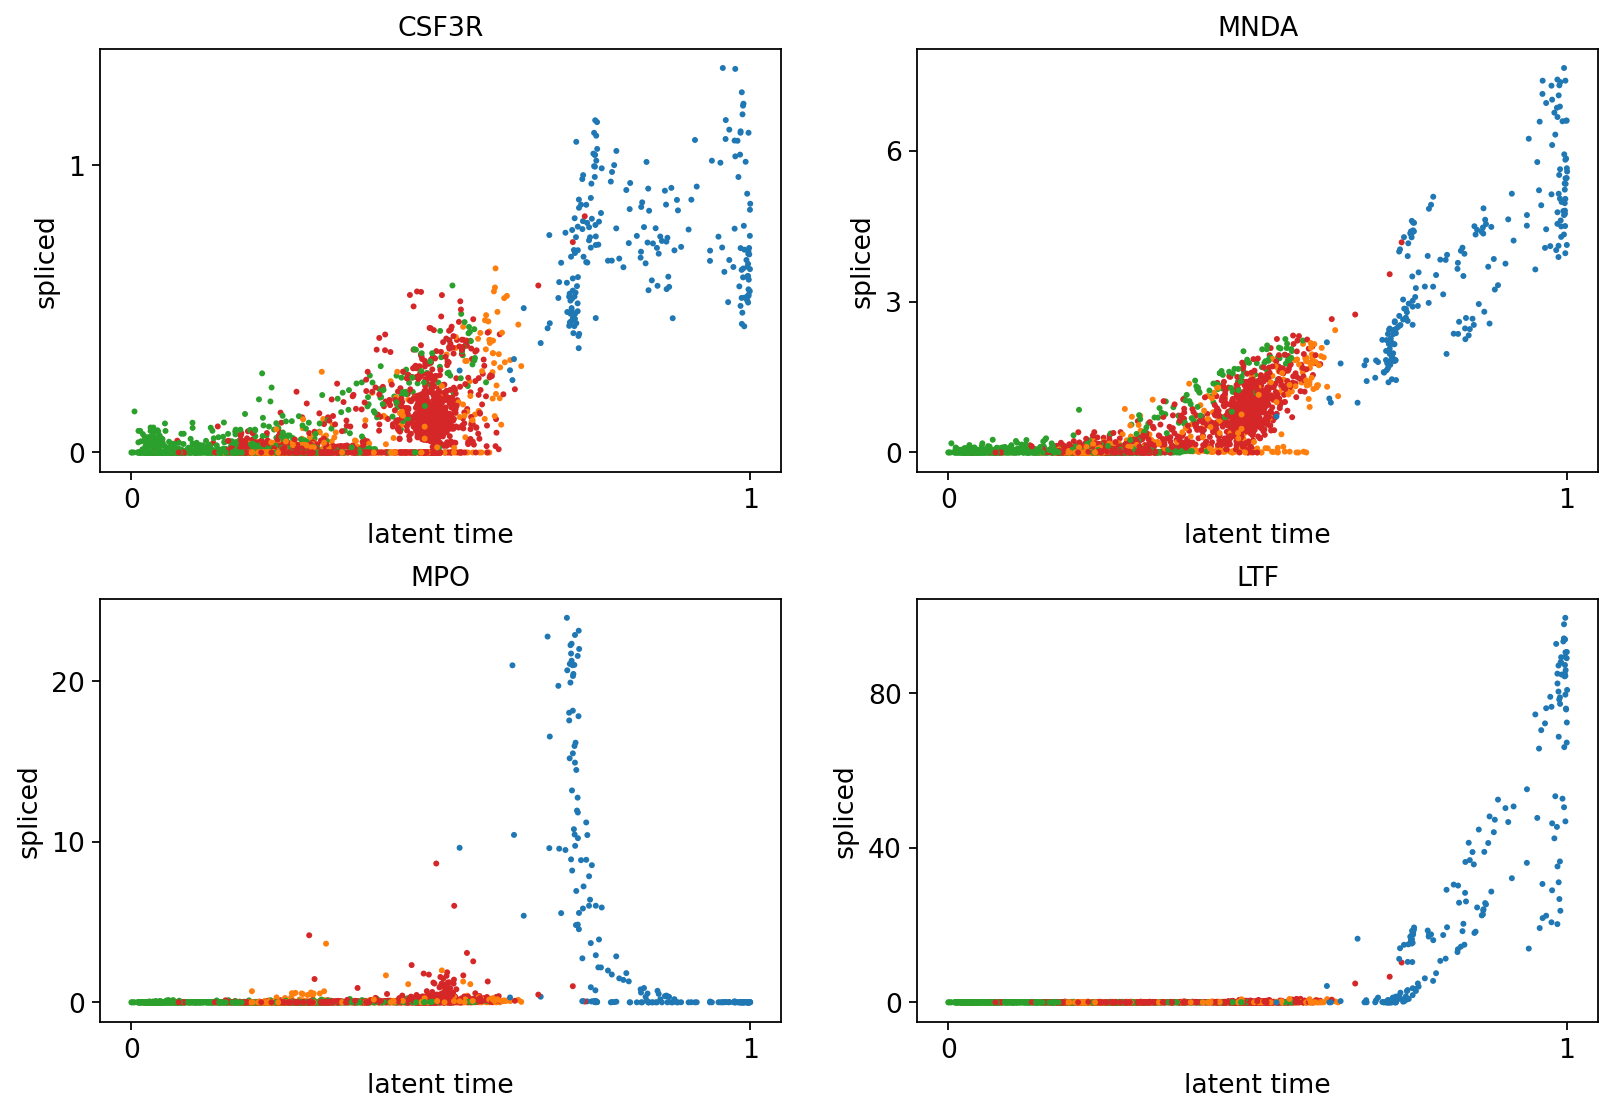

In [59]:
var_names = ['CSF3R', 'MNDA', 'MPO', 'LTF']
scv.pl.velocity(adata, var_names, color=color)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=True, color=color, ncols=2)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


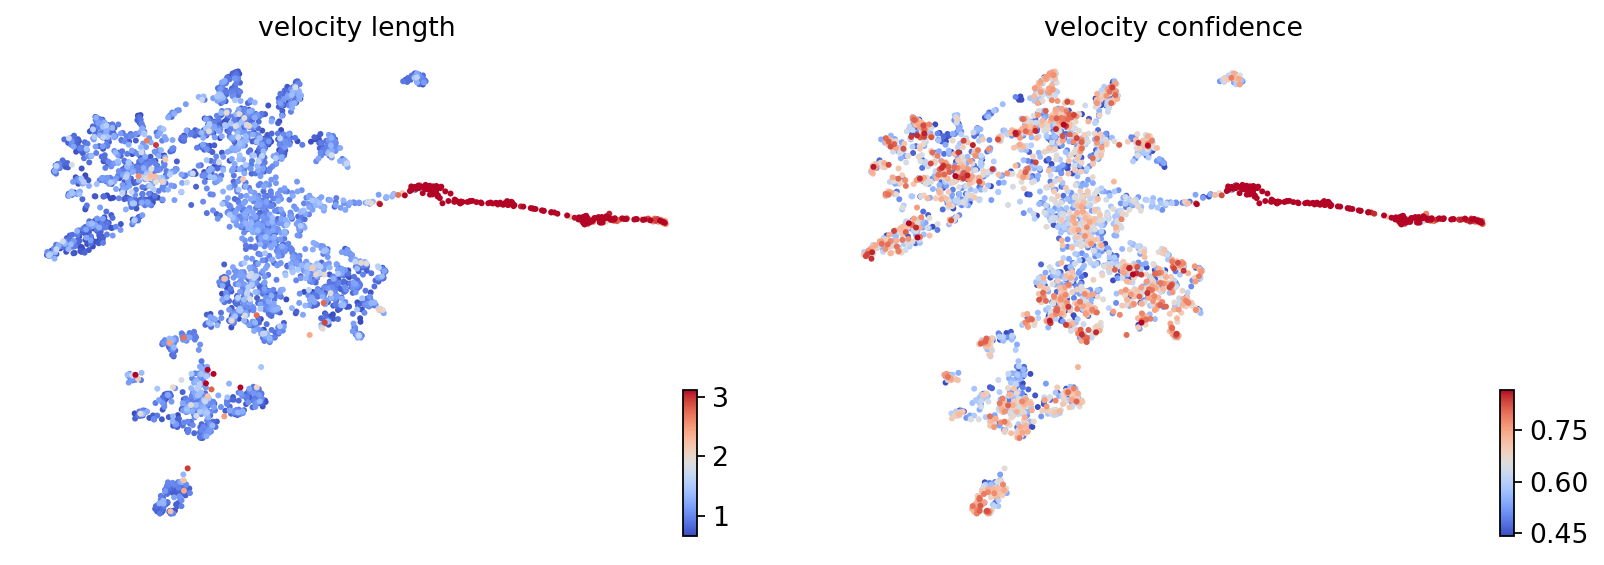

In [23]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

In [49]:
groups_paga='cell.type.fine'
scv.tl.paga(adata, groups=groups_paga)
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T

In [53]:
# df.index = ['Developing Neutrophil', 'IgA PB', 'IgG PB', 'IgM PB']
# df.columns = ['Developing Neutrophil', 'IgA PB', 'IgG PB', 'IgM PB']
# df

,Developing Neutrophil,IgA PB,IgG PB,IgM PB
Developing Neutrophil,0.00,0.0,0.00,0.00
IgA PB,0.00,0.0,0.00,0.07
IgG PB,0.00,0.0,0.00,0.00
IgM PB,0.01,0.0,0.53,0.00


In [54]:
df.style.background_gradient(cmap='Blues').format('{:.2g}')

,Developing Neutrophil,IgA PB,IgG PB,IgM PB
Developing Neutrophil,0,0,0,0
IgA PB,0,0,0,0.067
IgG PB,0,0,0,0
IgM PB,0.011,0,0.53,0


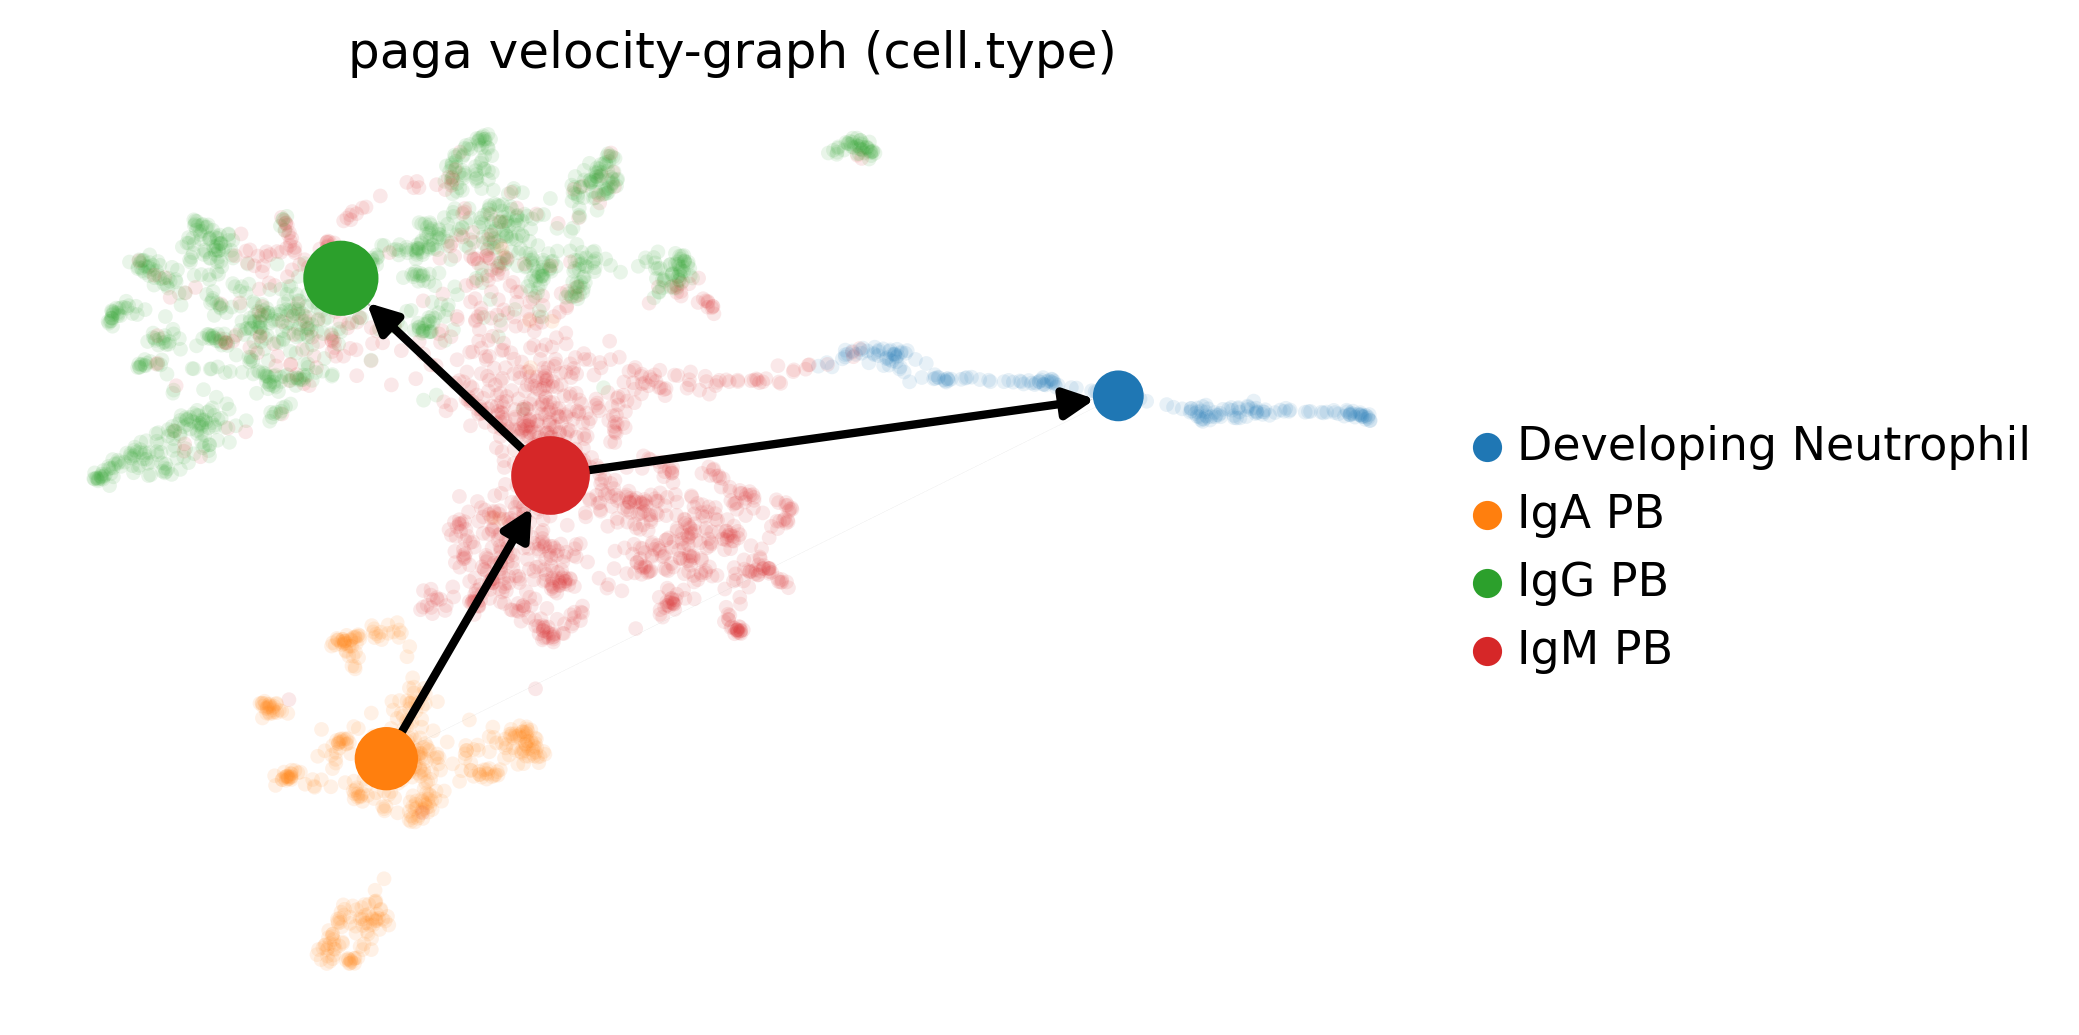

In [55]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

In [45]:
# 最后保存数据
adata.write('./Covid19.h5ad', compression='gzip')
# 最后保存数据

In [74]:
# type(adata.var.velocity_genes[adata.var.velocity_genes == True].index)

pandas.core.indexes.base.Index